# Assignment 3 
## Gemma Ragadini 545391

In [2]:
!pip install numpy torch seaborn scikit-learn matplotlib torchvision

In [3]:
# import libraries
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


## Dataset

I prepared and loaded the MNIST dataset using PyTorch. Next, I tried to inspect the first images from a batch to get an idea of what it contained, by displaying the first 4 along with their labels.

In [4]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

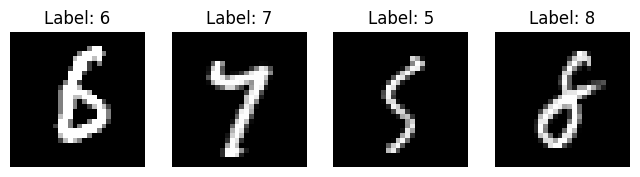

In [5]:
dataiter = iter(train_loader)
images, labels = next(dataiter)  
fig, axes = plt.subplots(1, 4, figsize=(8, 2))
for i in range(4):
    img = images[i].squeeze()  
    label = labels[i].item()
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')
plt.show()

## RMB implementation
This class implements a Restricted Boltzmann Machine (RBM) from scratch (PyTorch is used exclusively for tensor manipulation and basic mathematical operations).
The implementation supports Contrastive Divergence algorithm with a configurable number of Gibbs sampling steps (CD-k).
Key components:
- Initialization of model parameters: visible and hidden units, weight matrix, and biases
- Sampling methods: sample_h (hidden units given visibles) and sample_v (visibles given hiddens)
- Training using Contrastive Divergence: contrastive_divergence method
- Full training loop with monitoring of reconstruction loss (Mean Squared Error)
- Reconstruction function to test how well the RBM can regenerate input data
- Encoding function to extract the latent representation (hidden activations) of input data

This RBM is applied to the MNIST dataset to learn binary feature representations of handwritten digits.
These learned features are then used as input to a classifier to evaluate the quality of the representation.

In [10]:
class RBM:
  
    def __init__(self, num_v, num_h, k=1, lr=0.0001):
        self.num_v = num_v # visible units 
        self.num_h = num_h # hidden units 
        self.k = k # for CD-k
        self.lr = lr # learning rate
        self.WeightMatrix = torch.randn(num_h, num_v) * 0.01  # weight matrix
        self.h_bias = torch.zeros(num_h) # hidden bias
        self.v_bias = torch.zeros(num_v) # visible bias


    def sample_hidden(self, visible):
        wx = torch.matmul(visible, self.WeightMatrix.T) + self.h_bias
        activation_prob = torch.sigmoid(wx)
        hidden_sample = torch.bernoulli(activation_prob)
        return activation_prob, hidden_sample

    def sample_visible(self, hidden):
        wx = torch.matmul(hidden, self.WeightMatrix) + self.v_bias
        activation_prob = torch.sigmoid(wx)
        visible_sample = torch.bernoulli(activation_prob)
        return activation_prob, visible_sample

    # Contrastive Divergence algorithm (CD-k)
    def contrastive_divergence(self, v_init):
        v_neg = v_init.clone()
        # Perform k steps
        for _ in range(self.k):
            _, h_sampled = self.sample_hidden(v_neg)
            _, v_neg = self.sample_visible(h_sampled)
        # Positive and negative phase
        prob_h_pos, h_pos = self.sample_hidden(v_init)
        prob_h_neg, h_neg = self.sample_hidden(v_neg)
        # Parameter updates
        pos_grad = torch.matmul(h_pos.T, v_init)
        neg_grad = torch.matmul(h_neg.T, v_neg)
        self.WeightMatrix += self.lr * (pos_grad - neg_grad)
        self.v_bias += self.lr * torch.sum(v_init - v_neg, dim=0)
        self.h_bias += self.lr * torch.sum(h_pos - h_neg, dim=0)

    def train(self, train_loader, n_epochs=5):
        for epoch in range(n_epochs):
            loss = 0
            for images, _ in train_loader:
                images = images.view(-1, self.num_v)
                images = (images > 0.5).float()
                self.contrastive_divergence(images)
                loss += torch.mean((images - self.regenerate(images)) ** 2).item()
            print(f"Epoch {epoch + 1}, Loss: {loss / len(train_loader)}")

    # Reconstructs the input data after encoding and decoding
    def regenerate(self, input_visible):
        _, hidden_activations = self.sample_hidden(input_visible)
        reconstructed_prob, _ = self.sample_visible(hidden_activations)
        return reconstructed_prob

    # Encodes input into hidden representation (features)
    def encode(self, input_data):
        hidden_probabilities, _ = self.sample_hidden(input_data)
        return hidden_probabilities

In this section, I trained two Restricted Boltzmann Machines (RBMs) on the MNIST dataset using Contrastive Divergence with different values of k. The goal is to investigate how the number of Gibbs sampling steps (CD-1 vs CD-8) affects the learning process and the quality of the features extracted by the RBM. Both models are trained for 5 epochs on the MNIST training set.


In [11]:
num_v = 28 * 28 # Input dimension for MNIST images (28x28 pixels)
num_h = 512
# training
# RBM with K=1
print("k=1:")
rbm_k1 = RBM(num_v=num_v, num_h=num_h, k=1)
rbm_k1.train(train_loader, n_epochs=5)
# RBM with K=8
print("\nk=8:")
rbm_k8 = RBM(num_v=num_v, num_h=num_h, k=8)
rbm_k8.train(train_loader, n_epochs=5)

k=1:
Epoch 1, Loss: 0.07195859980672153
Epoch 2, Loss: 0.05213381088316949
Epoch 3, Loss: 0.04482243849889937
Epoch 4, Loss: 0.040293062784905624
Epoch 5, Loss: 0.037208231356638324

k=8:
Epoch 1, Loss: 0.07176846571997411
Epoch 2, Loss: 0.051649196164757966
Epoch 3, Loss: 0.04425181847995024
Epoch 4, Loss: 0.03968940799567364
Epoch 5, Loss: 0.03660737235806009


## Encoding a Selection of Test Images
The following code selects a subset of test images containing one digit from each class (0 to 9) and passes them through the RBM to visualize their encoding in the hidden layer. For each digit, the following are displayed:
- the original image;
- the activation of the hidden neurons resulting from the RBM encoding.

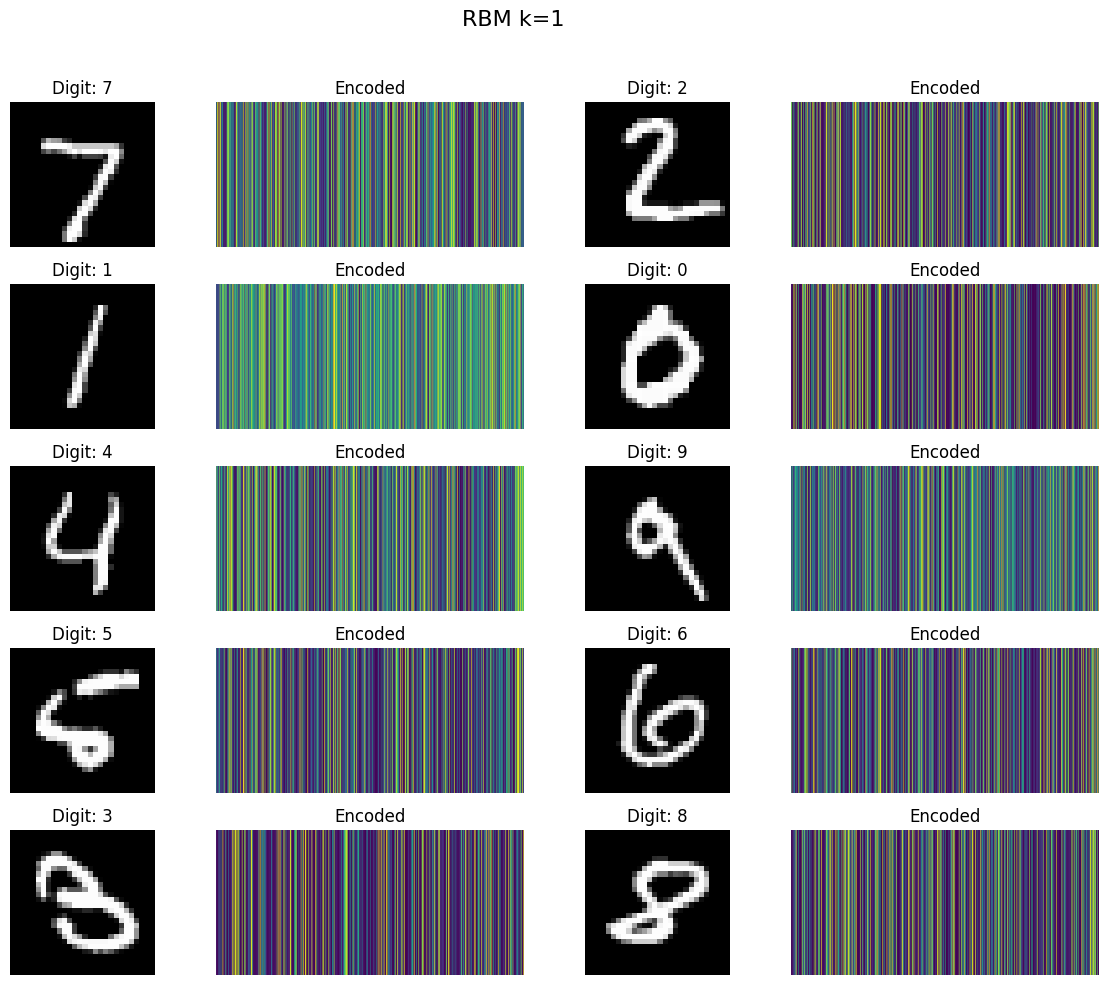

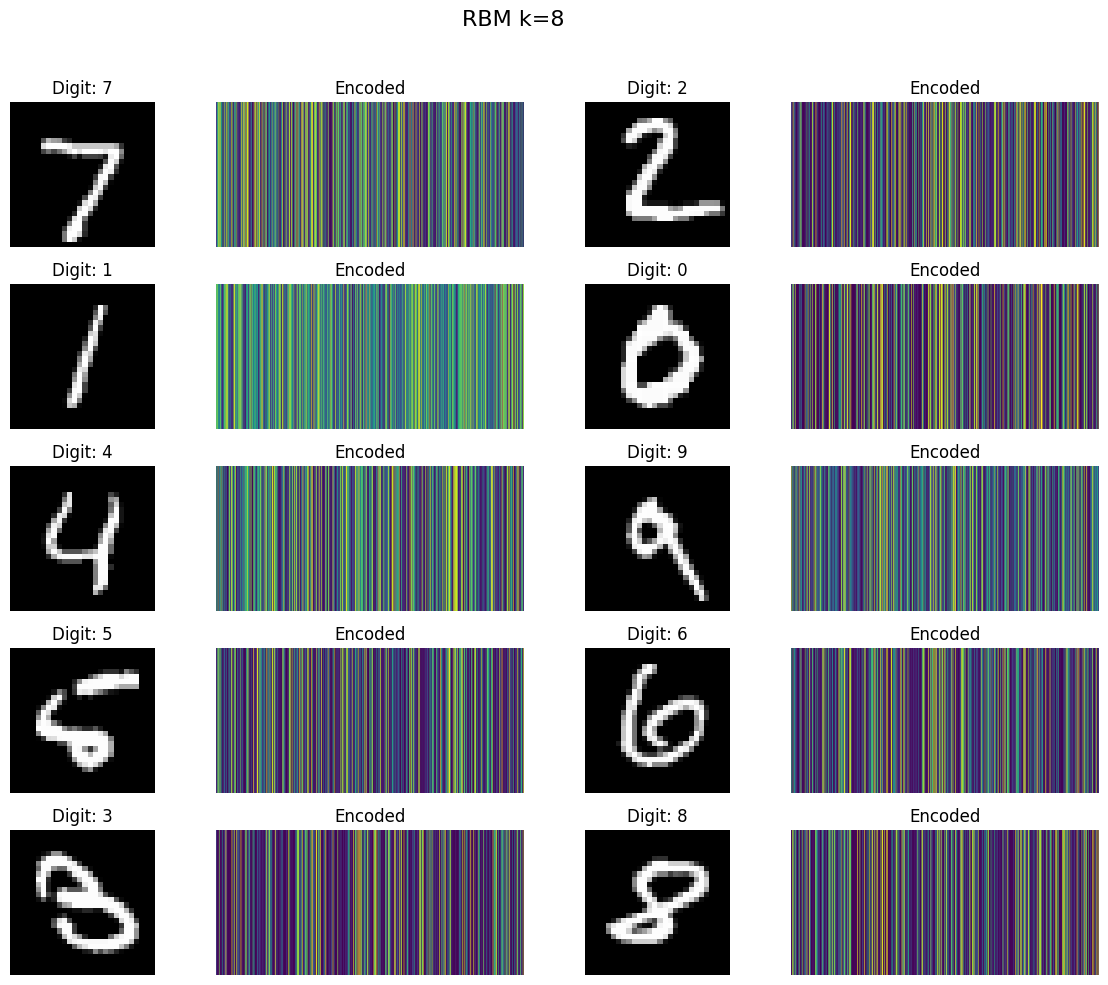

In [17]:
def show_encoded_examples(rbm, data_loader, title="RBM Encoded Features"):
    # Find one image for each digit from 0 to 9
    seen_digits = set()
    selected_images = []
    selected_labels = []

    for images, labels in data_loader:
        for img, lbl in zip(images, labels):
            if lbl.item() not in seen_digits:
                seen_digits.add(lbl.item())
                selected_images.append(img)
                selected_labels.append(lbl.item())
            if len(seen_digits) == 10:
                break
        if len(seen_digits) == 10:
            break

    # encode images
    images_tensor = torch.stack(selected_images)
    images_tensor = images_tensor.view(-1, 28*28)
    images_tensor = (images_tensor > 0.5).float()

    encoded_features = rbm.encode(images_tensor).detach().cpu().numpy()

    # show results in 5x2 layout (with 2 images per row)
    fig, axes = plt.subplots(5, 4, figsize=(12, 10))  # 5 rows, 4 columns
    for i in range(10):
        row = i // 2
        col = (i % 2) * 2

        # original image
        axes[row, col].imshow(selected_images[i].squeeze(), cmap='gray')
        axes[row, col].set_title(f"Digit: {selected_labels[i]}")
        axes[row, col].axis('off')

        # coding
        axes[row, col + 1].imshow(encoded_features[i].reshape(1, -1), cmap='viridis', aspect='auto')
        axes[row, col + 1].set_title("Encoded")
        axes[row, col + 1].axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Visualize for both RBMs
show_encoded_examples(rbm_k1, test_loader, title="RBM k=1")
show_encoded_examples(rbm_k8, test_loader, title="RBM k=8")

## Classification Using RBM-Encoded Features

In this section, I evaluate the quality of the representations learned by the RBM by using them as input features for a simple supervised classifier. The function `get_encoded_features` extracts the hidden layer activations for all images in the dataset. These features are then used to train a logistic regression model to classify the digits.
The process is repeated for both RBMs trained with CD-1 and CD-8. The classification accuracy on both the training and test sets is used as a performance metric to compare the usefulness of the learned representations.

In [18]:
def get_encoded_features(rbm, data_loader):
    features = []
    labels = []
    with torch.no_grad():
        for images, targets in data_loader:
            images = images.view(-1, 28*28)
            images = (images > 0.5).float()
            encoded = rbm.encode(images)
            features.append(encoded.numpy())
            labels.append(targets.numpy())
    return np.vstack(features), np.hstack(labels)

X_train_k1, y_train_k1 = get_encoded_features(rbm_k1, train_loader)
X_test_k1, y_test_k1 = get_encoded_features(rbm_k1, test_loader)

X_train_k8, y_train_k8 = get_encoded_features(rbm_k8, train_loader)
X_test_k8, y_test_k8 = get_encoded_features(rbm_k8, test_loader)
     
# classifiers
clf_k1 = LogisticRegression(max_iter=1000)
clf_k1.fit(X_train_k1, y_train_k1)

train_pred_k1 = clf_k1.predict(X_train_k1)
test_pred_k1 = clf_k1.predict(X_test_k1)

# Accuracy
train_acc_k1 = accuracy_score(y_train_k1, train_pred_k1)
test_acc_k1 = accuracy_score(y_test_k1, test_pred_k1)

clf_k8 = LogisticRegression(max_iter=1000)
clf_k8.fit(X_train_k8, y_train_k8)

train_pred_k8 = clf_k8.predict(X_train_k8)
test_pred_k8 = clf_k8.predict(X_test_k8)

train_acc_k8 = accuracy_score(y_train_k8, train_pred_k8)
test_acc_k8 = accuracy_score(y_test_k8, test_pred_k8)

print(f"RBM k=1 - Train Accuracy: {train_acc_k1 * 100:.2f}% | Test Accuracy: {test_acc_k1 * 100:.2f}%")
print(f"RBM k=8 - Train Accuracy: {train_acc_k8 * 100:.2f}% | Test Accuracy: {test_acc_k8 * 100:.2f}%")


RBM k=1 - Train Accuracy: 97.25% | Test Accuracy: 96.64%
RBM k=8 - Train Accuracy: 97.22% | Test Accuracy: 96.38%


## Results 
The results obtained with k=1 and k=8 are very similar in terms of classification accuracy on both the training and test sets. This suggests that even a small number of Gibbs sampling steps is sufficient to learn useful representations for this task. The added complexity of higher k does not seem to provide significant benefits in this case, possibly due to the simplicity of the MNIST dataset.